# **<font color="#42f5f5">8.0 Timeseries Analysis</font>**

## **<font color="#FBBF44">8.x Preprocessing</font>**

In [ ]:
!pip install awkward
import awkward as ak

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.8/610.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from collections import defaultdict
import librosa
from scipy.signal import decimate
import pathlib
from tqdm.notebook import tqdm

In [ ]:
dataset_folder = pathlib.Path("/content/drive/MyDrive/Data-Mining/RavdessAudioOnly")  # change it with your file location

In [ ]:
file_list = list(dataset_folder.iterdir())
for i, path in enumerate(file_list):
    if path.suffix != ".wav":
        file_list.pop(i)
file_list = sorted(file_list)
file_list

[PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-01.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-02.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-03.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-04.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-05.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-06.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-07.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-08.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-09.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-01-10.wav'),
 PosixPath('/content/drive/MyDrive/Data-Mining/RavdessAudioOnly/03-01-01-01-01-0

In [ ]:
array = list()
for path in tqdm(file_list):
    librosa_audio_segment, sr = librosa.load(path, sr=None)
    array.append([librosa_audio_segment])

  0%|          | 0/2452 [00:00<?, ?it/s]

In [ ]:
b = ak.ArrayBuilder()
for path in tqdm(file_list):
    librosa_audio_segment, sr = librosa.load(path, sr=None)
    b.begin_list()
    b.begin_list()
    for value in librosa_audio_segment:
        b.real(value)
    b.end_list()
    b.end_list()
array = b.snapshot()

  0%|          | 0/2452 [00:00<?, ?it/s]

In [ ]:
CATEGORICAL_FEATURES_NAMES = {
    "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"},
    "vocal_channel": {"01": "speech", "02": "song"},
    "emotion": {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : "fearful", "07" : "disgust", "08" : "surprised"},
    "emotional_intensity": {"01" : "normal", "02" : "strong"},
    "statement": {"01" : "Kids are talking by the door", "02" : "Dogs are sitting by the door"},
    "repetition": {"01" : "1st", "02" : "2nd"},
    "actor": {str(i).zfill(2): str(i).zfill(2) for i in range(1, 25)}
}

In [ ]:
df = list()
file_names = list()
for path in file_list:
    stem = path.stem.split("-")
    file_names.append(path.name)
    df.append(stem)
df = pd.DataFrame(df)
df.columns = list(CATEGORICAL_FEATURES_NAMES.keys())

for column in df.columns:
    df = df.replace(CATEGORICAL_FEATURES_NAMES)

df["sex"] = ["F" if i % 2 == 0 else "M" for i in df["actor"].astype(int)]
df["filename"] = file_names

In [ ]:
df.head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename
0,audio-only,speech,neutral,normal,Kids are talking by the door,1st,01,M,03-01-01-01-01-01-01.wav
1,audio-only,speech,neutral,normal,Kids are talking by the door,1st,02,F,03-01-01-01-01-01-02.wav
2,audio-only,speech,neutral,normal,Kids are talking by the door,1st,03,M,03-01-01-01-01-01-03.wav
3,audio-only,speech,neutral,normal,Kids are talking by the door,1st,04,F,03-01-01-01-01-01-04.wav
4,audio-only,speech,neutral,normal,Kids are talking by the door,1st,05,M,03-01-01-01-01-01-05.wav


In [ ]:
df.shape

(2452, 9)

In [ ]:
df_sorted_actor = df.sort_values(by=["actor", "filename"])
idxs_sorted = list(df_sorted_actor.index)

In [ ]:
df_sorted_actor

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename
0,audio-only,speech,neutral,normal,Kids are talking by the door,1st,01,M,03-01-01-01-01-01-01.wav
24,audio-only,speech,neutral,normal,Kids are talking by the door,2nd,01,M,03-01-01-01-01-02-01.wav
48,audio-only,speech,neutral,normal,Dogs are sitting by the door,1st,01,M,03-01-01-01-02-01-01.wav
72,audio-only,speech,neutral,normal,Dogs are sitting by the door,2nd,01,M,03-01-01-01-02-02-01.wav
96,audio-only,speech,calm,normal,Kids are talking by the door,1st,01,M,03-01-02-01-01-01-01.wav
...,...,...,...,...,...,...,...,...,...
2359,audio-only,song,fearful,normal,Dogs are sitting by the door,2nd,24,F,03-02-06-01-02-02-24.wav
2382,audio-only,song,fearful,strong,Kids are talking by the door,1st,24,F,03-02-06-02-01-01-24.wav
2405,audio-only,song,fearful,strong,Kids are talking by the door,2nd,24,F,03-02-06-02-01-02-24.wav
2428,audio-only,song,fearful,strong,Dogs are sitting by the door,1st,24,F,03-02-06-02-02-01-24.wav


In [ ]:
idx_train = list(df_sorted_actor[df_sorted_actor.actor.astype(int) < 19].index)
idx_test = list(df_sorted_actor[df_sorted_actor.actor.astype(int) >= 19].index)

In [ ]:
len(idx_test)

624

In [ ]:
len(idx_train)

1828

In [ ]:
X_train = array[idx_train]
X_test = array[idx_test]
Y_train = df_sorted_actor[df_sorted_actor.actor.astype(int) < 19]
Y_test = df_sorted_actor[df_sorted_actor.actor.astype(int) >= 19]

In [ ]:
def pad_X(X, m_max, nan_value=0):
    return ak.fill_none(ak.pad_none(X, m_max, axis=2, clip=True), value=nan_value)

In [ ]:
# find the max length of X_train
maximum = 0
for ts in X_train:
    length = len(np.asarray(np.ravel(ts)))
    if length > maximum:
        maximum = length
maximum

304304

In [ ]:
X_train = np.squeeze(np.array(pad_X(X_train, maximum, np.nan)))
X_test = np.squeeze(np.array(pad_X(X_test, maximum, np.nan)))

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

NameError: ignored

In [ ]:
np.save("RavdessAudioOnlyNumpy__X_train.npy", X_train)
np.save("RavdessAudioOnlyNumpy__X_test.npy", X_test)

## **<font color="#FBBF44">8.x Data Loading</font>**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Audio
from collections import defaultdict
import librosa
from scipy.signal import decimate
import pathlib
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load("/content/drive/MyDrive/Data-Mining/timeseries/RavdessAudioOnlyNumpy__X_train-trimmed.npy")
X_test = np.load("/content/drive/MyDrive/Data-Mining/timeseries/RavdessAudioOnlyNumpy__X_test-trimmed.npy")
print(X_train.shape, X_test.shape)

(1828, 110080) (624, 110080)


In [ ]:
Y_train = pd.read_csv("/content/drive/MyDrive/Data-Mining/timeseries/RavdessAudioOnlyNumpy__Y_train.csv", skipinitialspace=True)
Y_test = pd.read_csv("/content/drive/MyDrive/Data-Mining/timeseries/RavdessAudioOnlyNumpy__Y_test.csv", skipinitialspace=True)

## **<font color="#FBBF44">8.x Understanding</font>**

In [ ]:
# Calcoliamo i features

def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }
    return features

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1828, 304304)
(624, 304304)


In [ ]:
df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)

In [ ]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,304294,304295,304296,304297,304298,304299,304300,304301,304302,304303
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,-0.000031,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000031,0.000031,0.000000,0.000031,0.000031,0.000031,0.000061,0.0,0.000031,0.000031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000031,0.000031,0.000031,0.000031,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_ts = (df_train-df_train.min())/(df_train.max()-df_train.min())
data_test_ts = (df_test-df_test.min())/(df_test.max()-df_test.min())

data_ts.shape
data_ts

## **<font color="#FBBF44">8.x Clustering</font>**

### Preprocessing

In [ ]:
def plot_time_series_parallel(num_elements, time_series_list1, time_series_list2):
    fig, axs = plt.subplots(num_elements, 2, figsize=(8, num_elements * 1.5), sharey=False)

    for i in range(num_elements):
        axs[i, 0].plot(time_series_list1[i])
        axs[i, 1].plot(time_series_list2[i])
        axs[i, 0].set_xticks([])
        axs[i, 0].set_yticks([])
        axs[i, 1].set_xticks([])
        axs[i, 1].set_yticks([])

    plt.tight_layout()
    plt.show()

In [ ]:
mask_fearfulM = (Y_train['emotion']=='fearful')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')

indices_fearfulM = Y_train.index[mask_fearfulM]

mask_surprisedM = (Y_train['emotion']=='surprised')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')

indices_surprisedM = Y_train.index[mask_surprisedM]

mask_happyM = (Y_train['emotion']=='happy')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')

indices_happyM = Y_train.index[mask_happyM]

mask_sadM = (Y_train['emotion']=='sad')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')

indices_sadM = Y_train.index[mask_sadM]

mask_neutralM = (Y_train['emotion']=='neutral')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')

indices_neutralM = Y_train.index[mask_neutralM]

mask_calmM = (Y_train['emotion']=='calm')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')

indices_calmM = Y_train.index[mask_calmM]

mask_angryM = (Y_train['emotion']=='angry')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')

indices_angryM = Y_train.index[mask_angryM]

mask_disgustM = (Y_train['emotion']=='disgust')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')&(Y_train["emotional_intensity"]=='normal')&(Y_train["vocal_channel"]=='speech')

indices_disgustM = Y_train.index[mask_disgustM]


In [ ]:
mask_male = (Y_train['sex']=='M')

indices_male = Y_train.index[mask_male]


In [ ]:
mask_happyM = (Y_train['emotion']=='happy')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_happyM = Y_train.index[mask_happyM]

mask_happyF = (Y_train['emotion']=='happy')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_happyF = Y_train.index[mask_happyF]

mask_sadM = (Y_train['emotion']=='sad')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_sadM = Y_train.index[mask_sadM]

mask_sadF = (Y_train['emotion']=='sad')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_sadF = Y_train.index[mask_sadF]

mask_calmM = (Y_train['emotion']=='calm')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_calmM = Y_train.index[mask_calmM]

mask_calmF = (Y_train['emotion']=='calm')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_calmF = Y_train.index[mask_calmF]

mask_angryM = (Y_train['emotion']=='angry')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_angryM = Y_train.index[mask_angryM]

mask_angryF = (Y_train['emotion']=='angry')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_angryF = Y_train.index[mask_angryF]


In [ ]:
indices_calmM, indices_fearfulM, indices_happyM, indices_sadM

(Int64Index([   4,    5,  212,  213,  420,  421,  628,  629,  836,  837, 1044,
             1045, 1252, 1253, 1460, 1461, 1668, 1669],
            dtype='int64'),
 Int64Index([  36,   37,  244,  245,  452,  453,  660,  661,  868,  869, 1076,
             1077, 1284, 1285, 1492, 1493, 1700, 1701],
            dtype='int64'),
 Int64Index([  12,   13,  220,  221,  428,  429,  636,  637,  844,  845, 1052,
             1053, 1260, 1261, 1468, 1469, 1676, 1677],
            dtype='int64'),
 Int64Index([  20,   21,  228,  229,  436,  437,  644,  645,  852,  853, 1060,
             1061, 1268, 1269, 1476, 1477, 1684, 1685],
            dtype='int64'))

In [ ]:
X_train_male = X_train[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]


In [ ]:
len(X_train_male)

560

In [ ]:
X_train_male_ = np.array([row[row != 0] for row in X_train_male])

<ipython-input-13-528e58c05978>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_male_ = np.array([row[row != 0] for row in X_train_male])


In [ ]:
# find the max length of X_train
maximum = 0
for ts in X_train_male_:
    length = len(np.asarray(np.ravel(ts)))
    if length > maximum:
        maximum = length
maximum

91648

In [ ]:
# find the min length of X_train
minimum = 1000000000
for ts in X_train_male_:
    length = len(np.asarray(np.ravel(ts)))
    if length < minimum:
        minimum = length
minimum

19456

In [ ]:
X_train_male = np.array([list(row) + [0] * (maximum - len(row)) for row in X_train_male_])

In [ ]:
X_train_male

array([[-0.00195117, -0.00190406,  0.00020211, ...,  0.        ,
         0.        ,  0.        ],
       [-0.00263958, -0.00065807,  0.00195521, ...,  0.        ,
         0.        ,  0.        ],
       [-0.0014799 ,  0.00016778,  0.00164539, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.00079589, -0.00041099, -0.00146668, ...,  0.        ,
         0.        ,  0.        ],
       [-0.03818404, -0.04891307,  0.0235982 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.02106962,  0.00610096, -0.01400467, ...,  0.        ,
         0.        ,  0.        ]])

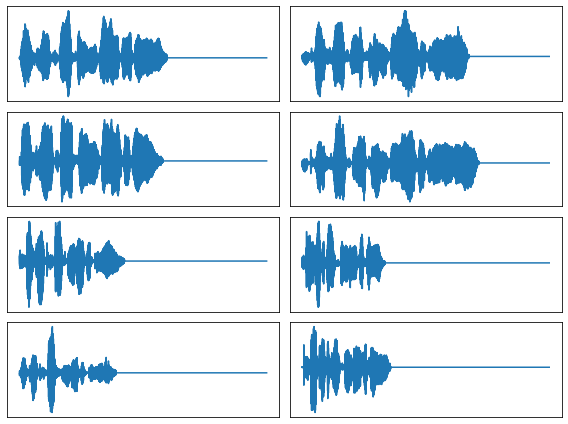

In [ ]:
plot_time_series_parallel(4, X_train_male[[4,5,212,213]], X_train_male[[36,37,244,245]])

### Clustering Scaled

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df_train = df_train.fillna(0)

In [ ]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,110070,110071,110072,110073,110074,110075,110076,110077,110078,110079
0,-8.057224e-04,-3.283176e-04,-0.000065,-1.209115e-03,4.391285e-04,0.000154,0.000549,0.000175,-0.000104,-0.000510,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-7.862622e-04,-3.568530e-04,0.001548,1.282181e-03,-5.370758e-04,-0.000807,-0.000195,-0.000306,-0.000741,-0.000500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-6.049065e-05,-6.880034e-05,-0.000046,-5.696920e-05,-3.639493e-05,-0.000042,-0.000033,-0.000034,-0.000039,-0.000050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.630225e-06,-1.263025e-05,-0.000004,-6.350892e-07,1.989469e-06,0.000010,0.000006,-0.000008,0.000021,0.000053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.534826e-03,-1.611449e-03,0.000145,8.428624e-05,9.925762e-04,0.000619,0.000405,0.000581,-0.000519,-0.001570,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,1.338943e-05,-1.552358e-07,0.000001,-2.994470e-06,1.054640e-05,0.000056,0.000008,-0.000006,0.000054,0.000025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1824,4.103486e-03,-7.588537e-04,-0.006052,-7.044603e-03,1.100412e-03,-0.000331,-0.001768,0.000557,-0.003226,-0.001278,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1825,3.303012e-03,2.027737e-03,0.000321,9.759187e-04,3.164094e-03,-0.000950,-0.000480,-0.000162,0.004451,0.001632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1826,-8.775861e-07,-1.101770e-06,-0.000014,1.878861e-06,5.462438e-07,-0.000020,-0.000028,0.000008,-0.000009,-0.000007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train_scaled = scaler.fit_transform(df_train.T).T

In [ ]:
df_train_scaled

array([[0.46968399, 0.47573872, 0.47908133, ..., 0.47990265, 0.47990265,
        0.47990265],
       [0.46369056, 0.46849126, 0.48978489, ..., 0.4724808 , 0.4724808 ,
        0.4724808 ],
       [0.38361625, 0.38352915, 0.38377015, ..., 0.38425031, 0.38425031,
        0.38425031],
       ...,
       [0.4827066 , 0.47215383, 0.45803065, ..., 0.45537451, 0.45537451,
        0.45537451],
       [0.49362544, 0.4936238 , 0.49352735, ..., 0.49363186, 0.49363186,
        0.49363186],
       [0.54870247, 0.54865345, 0.54878025, ..., 0.5488527 , 0.5488527 ,
        0.5488527 ]])

In [ ]:
df_train_scaled.shape

(1828, 110080)

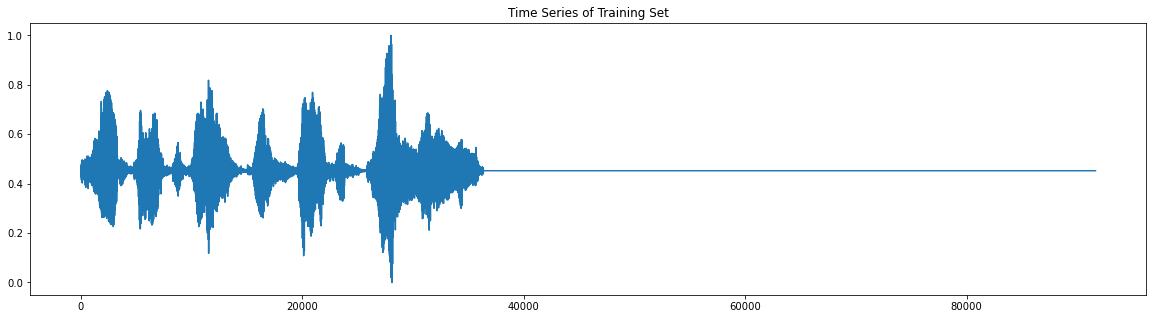

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(df_train_scaled[123])
plt.title("Time Series of Training Set")
# plt.xlim([50000, 51200])
plt.show()

In [ ]:
n_paa_segments = 5000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
ts_paa = paa.fit_transform(df_train_scaled)

ts_paa.shape

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 1828 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(1828, 5000, 1)

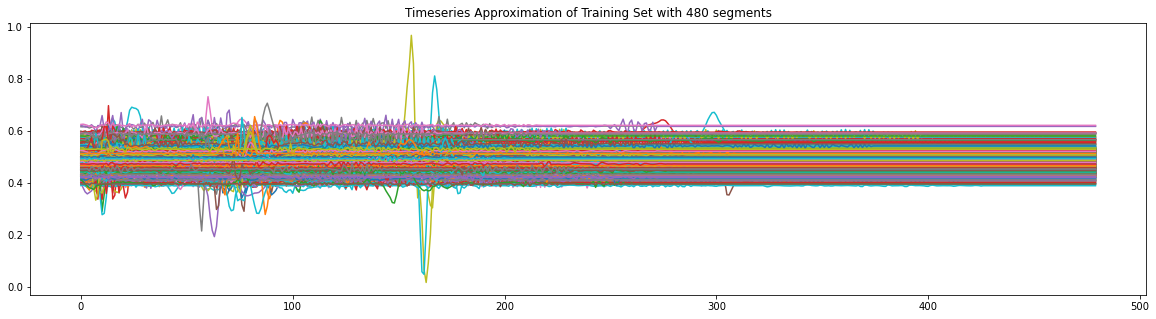

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ts_paa[:,:,0].T)
# plt.xlim([1800, 1825])
plt.title("Timeseries Approximation of Training Set with {} segments".format(n_paa_segments))
plt.show()

In [ ]:
%%time
sse_list = []
for k in range(2, 20):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100)
    kmeans.fit(ts_paa)
    sse_list.append(kmeans.inertia_)

CPU times: user 1min 1s, sys: 12.4 s, total: 1min 14s
Wall time: 44.5 s


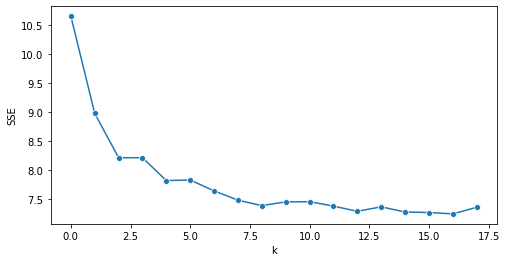

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [ ]:
kmeans = TimeSeriesKMeans(n_clusters=4, metric="euclidean")
kmeans.fit(ts_paa)

TimeSeriesKMeans(n_clusters=4)

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(ts_paa[:,:,0], kmeans.labels_))

labels {0: 631, 1: 225, 2: 334, 3: 638}
sse 8.223730250005755
silhouette 0.14805255090004923


(4, 5000, 1)


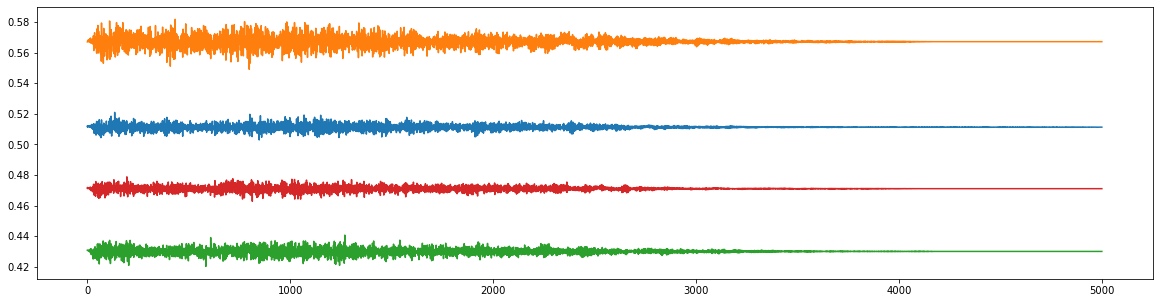

In [ ]:
print(kmeans.cluster_centers_.shape)
plt.figure(figsize=(20,5))
plt.plot(np.squeeze(kmeans.cluster_centers_).T)
# plt.xlim([0, 127])
plt.show()

<ipython-input-37-6943142ead8e>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2, c='c')


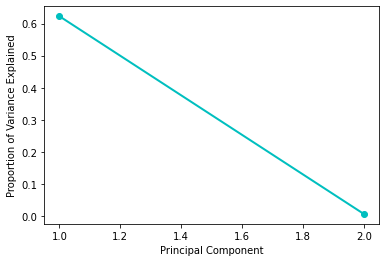

In [ ]:
# Cerchiamo valore ottimo di componenti
pca = PCA(n_components=2)
Principal_components=pca.fit_transform(ts_paa[:,:,0])

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2, c='c')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [ ]:
Principal_components_paa = Principal_components.reshape((Principal_components.shape[0], Principal_components.shape[1], 1))

In [ ]:
Principal_components_paa.shape

(560, 2, 1)

In [ ]:
metric_p = {
    "global_constraint": "itakura",
    "itakura_max_slope": 2.
}

In [ ]:
%%time
sse_list = []
for k in range(2, 20):
    kmeans = TimeSeriesKMeans(n_clusters=4, metric="dtw", metric_params=metric_p)
    kmeans.fit(Principal_components_paa)
    sse_list.append(kmeans.inertia_)

CPU times: user 32.2 s, sys: 197 ms, total: 32.4 s
Wall time: 32.4 s


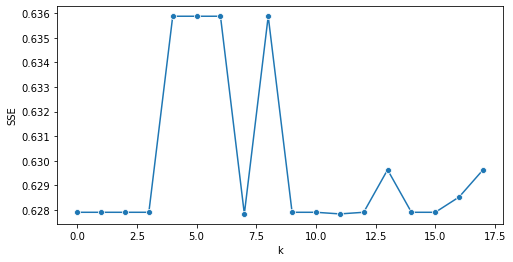

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [ ]:
kmeans = TimeSeriesKMeans(n_clusters=3, metric="dtw", metric_params=metric_p)
kmeans.fit(ts_paa)

TimeSeriesKMeans(metric='dtw',
                 metric_params={'global_constraint': 'itakura',
                                'itakura_max_slope': 2.0})

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(ts_paa[:,:,0], kmeans.labels_))

labels {0: 275, 1: 235, 2: 50}
sse 0.1115442035438426
silhouette 0.5209777002570678


(3, 480, 1)


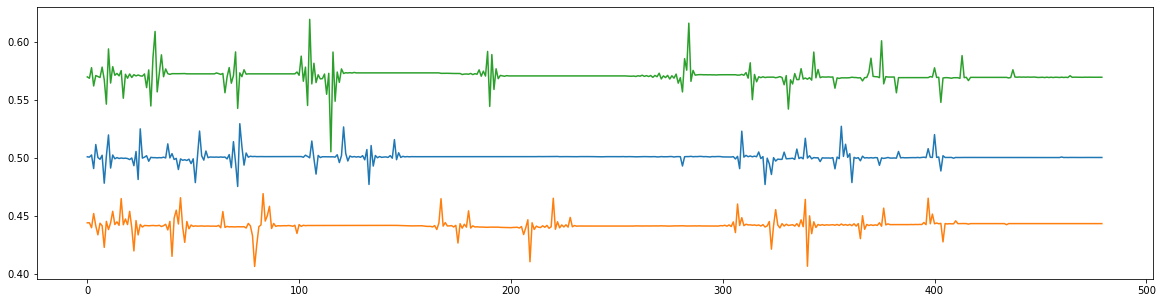

In [ ]:
print(kmeans.cluster_centers_.shape)
plt.figure(figsize=(20,5))
plt.plot(np.squeeze(kmeans.cluster_centers_).T)
# plt.xlim([0, 127])
plt.show()

### Feature Based Clustering

In [ ]:
# Calcoliamo i features

def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }
    return features

In [ ]:
F = [list(calculate_features(x).values())[:-2] for x in X_train]

In [ ]:
%%time
sse_list = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(F)
    sse_list.append(kmeans.inertia_)

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

CPU times: user 3.88 s, sys: 2.51 s, total: 6.39 s
Wall time: 1.13 s


/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


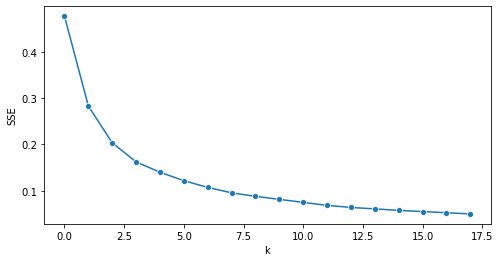

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(F)

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(ts_paa[:,:,0], kmeans.labels_))

labels {0: 503, 1: 1180, 2: 145}
sse 0.2828596377030206
silhouette -0.08973321861932498


(3, 11)


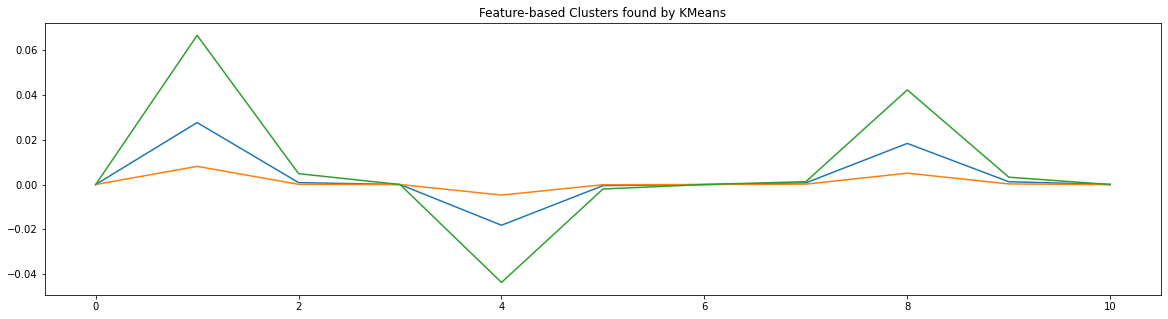

In [ ]:
print(kmeans.cluster_centers_.shape)
plt.figure(figsize=(20,5))
plt.plot(np.squeeze(kmeans.cluster_centers_).T)
plt.title("Feature-based Clusters found by KMeans")
# plt.xlim([0, 2000])
plt.show()

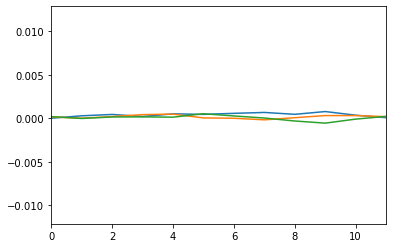

In [ ]:
for i in range(3):
    plt.plot(np.mean(X_train[np.where(kmeans.labels_ == i)[0]], axis=0))

plt.xlim([0, 11])
plt.show()

### Clustering with Four Classes

In [ ]:
scaler = TimeSeriesScalerMinMax()
X_train = scaler.fit_transform(X_train)

In [ ]:
X_train_offset = X_train - X_train.mean()

In [ ]:
n_paa_segments = 5000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_train_paa = paa.fit_transform(X_train)

X_train_paa.shape

(72, 5000, 1)

In [ ]:
X_train_offset_paa = paa.fit_transform(X_train)

X_train_offset_paa.shape

(72, 5000, 1)

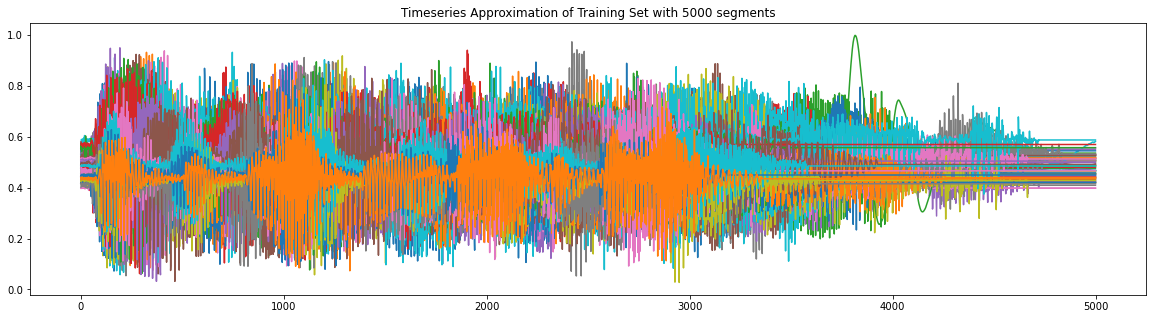

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(X_train_paa[:,:,0].T)
# plt.xlim([1800, 1825])
plt.title("Timeseries Approximation of Training Set with {} segments".format(n_paa_segments))
plt.show()

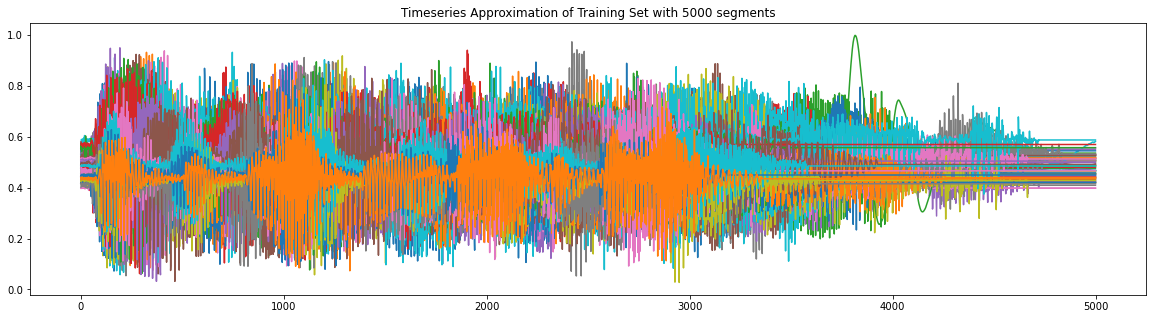

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(X_train_offset_paa[:,:,0].T)
# plt.xlim([1800, 1825])
plt.title("Timeseries Approximation of Training Set with {} segments".format(n_paa_segments))
plt.show()

In [ ]:
%%time
sse_list = []
for k in range(2, 20):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100)
    kmeans.fit(X_train_paa)
    sse_list.append(kmeans.inertia_)

CPU times: user 2.74 s, sys: 743 ms, total: 3.48 s
Wall time: 478 ms


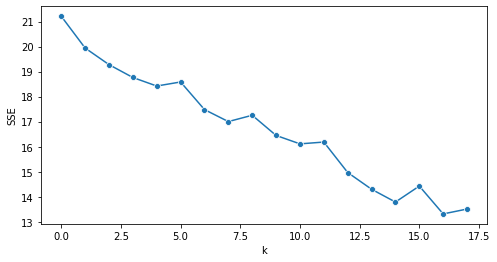

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [ ]:
kmeans = TimeSeriesKMeans(n_clusters=4, metric="euclidean")
kmeans.fit(X_train_paa)

TimeSeriesKMeans(n_clusters=4)

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(X_train_paa[:,:,0], kmeans.labels_))

labels {0: 1, 1: 36, 2: 34, 3: 1}
sse 20.151265785590176
silhouette 0.1721504839594936


(4, 5000, 1)


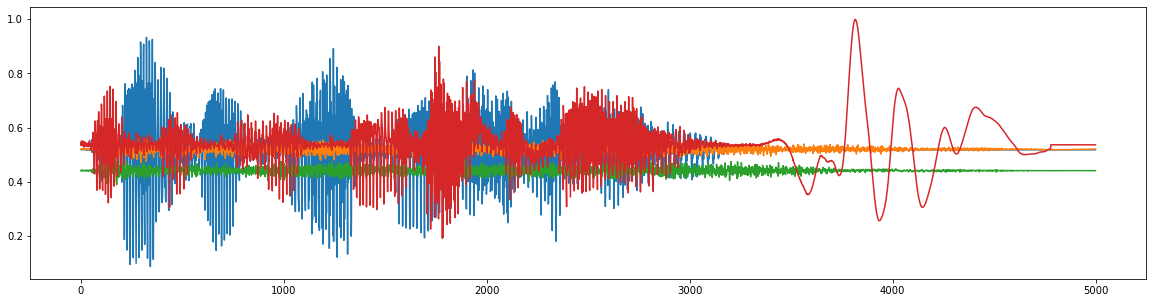

In [ ]:
print(kmeans.cluster_centers_.shape)
plt.figure(figsize=(20,5))
plt.plot(np.squeeze(kmeans.cluster_centers_).T)
# plt.xlim([0, 127])
plt.show()

In [ ]:
%%time
sse_list = []
for k in range(2, 20):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100)
    kmeans.fit(X_train_offset_paa)
    sse_list.append(kmeans.inertia_)

CPU times: user 2.69 s, sys: 719 ms, total: 3.41 s
Wall time: 464 ms


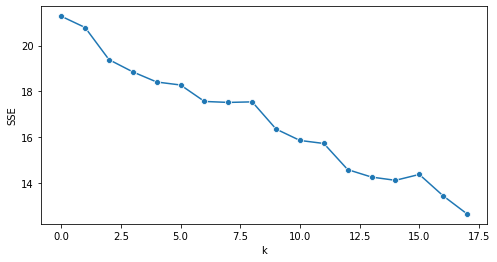

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [ ]:
kmeans = TimeSeriesKMeans(n_clusters=6, metric="euclidean")
kmeans.fit(X_train_offset_paa)

TimeSeriesKMeans(n_clusters=6)

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(X_train_offset_paa[:,:,0], kmeans.labels_))

labels {0: 1, 1: 1, 2: 21, 3: 6, 4: 16, 5: 27}
sse 18.27545307631162
silhouette 0.05957895584895222


(6, 5000, 1)


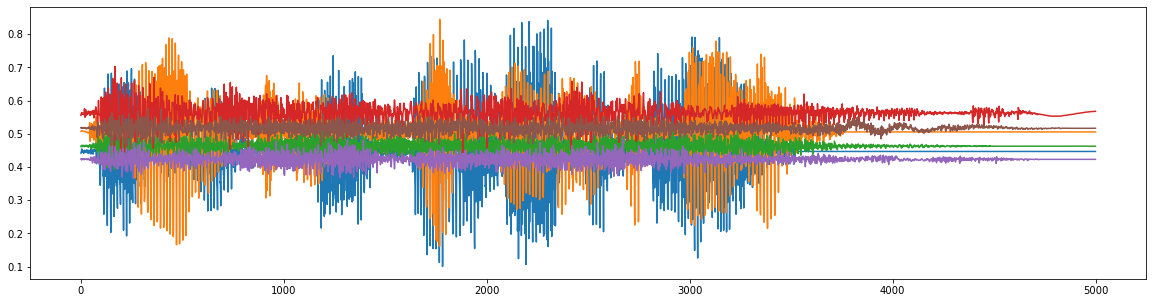

In [ ]:
print(kmeans.cluster_centers_.shape)
plt.figure(figsize=(20,5))
plt.plot(np.squeeze(kmeans.cluster_centers_).T)
# plt.xlim([0, 127])
plt.show()

### Clustering with All

In [ ]:
scaler = TimeSeriesScalerMinMax()
X_train_male = scaler.fit_transform(X_train_male)

In [ ]:
n_paa_segments = 5000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_train_paa = paa.fit_transform(X_train_male)

X_train_paa.shape

(936, 5000, 1)

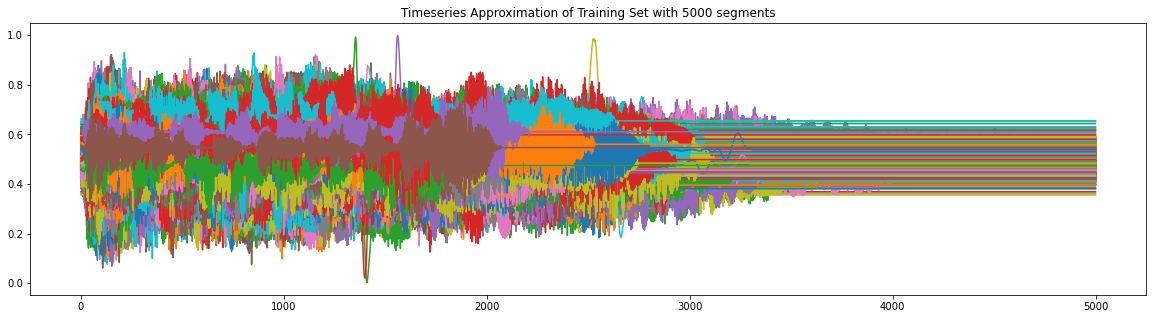

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(X_train_paa[:,:,0].T)
# plt.xlim([1800, 1825])
plt.title("Timeseries Approximation of Training Set with {} segments".format(n_paa_segments))
plt.show()

In [ ]:
%%time
sse_list = []
for k in range(2, 20):
    kmeans = TimeSeriesKMeans(n_clusters=k, metric="euclidean", max_iter=100)
    kmeans.fit(X_train_paa)
    sse_list.append(kmeans.inertia_)

CPU times: user 34.5 s, sys: 7.99 s, total: 42.5 s
Wall time: 15.7 s


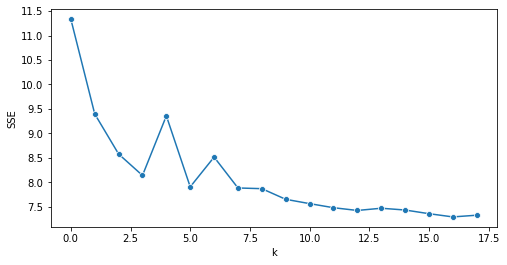

In [ ]:
plt.figure(figsize=(8,4))
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.show()

In [ ]:
kmeans = TimeSeriesKMeans(n_clusters=5, metric="euclidean")
kmeans.fit(X_train_paa)

TimeSeriesKMeans(n_clusters=5)

In [ ]:
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(X_train_paa[:,:,0], kmeans.labels_))

labels {0: 88, 1: 264, 2: 258, 3: 110, 4: 216}
sse 8.147823042010382
silhouette 0.11780647482957561


(5, 5000, 1)


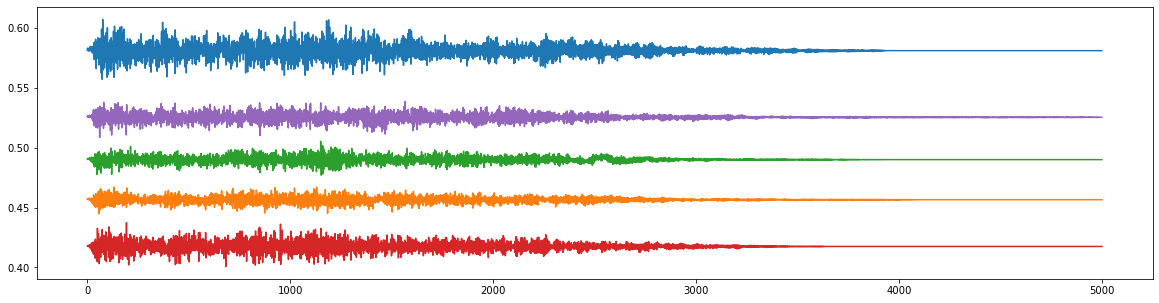

In [ ]:
print(kmeans.cluster_centers_.shape)
plt.figure(figsize=(20,5))
plt.plot(np.squeeze(kmeans.cluster_centers_).T)
# plt.xlim([0, 127])
plt.show()

### Cluster Analysis

In [ ]:
clusters = kmeans.cluster_centers_

In [ ]:
np.save("/Users/mumer/My Data/Unipi - Study Material/Semester - 2nd/Data Mining - II/Project/Dataset/RavdessAudioOnlyNumpy__X_train-clusters-euclidean.npy", clusters)


In [ ]:
clusters = np.load("/Users/mumer/My Data/Unipi - Study Material/Semester - 2nd/Data Mining - II/Project/Dataset/RavdessAudioOnlyNumpy__X_train-clusters-euclidean.npy")


#### Visualization

In [ ]:
label = kmeans.labels_
u_labels = np.unique(kmeans.labels_)

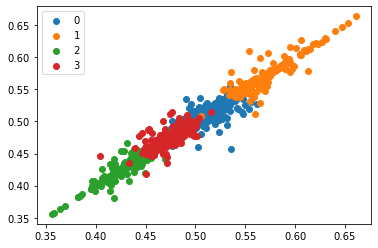

In [ ]:
for i in u_labels:
    plt.scatter(ts_paa[label == i , 0] , ts_paa[label == i , 1] , label = i)
plt.legend()
plt.show()

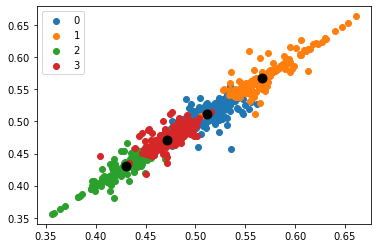

In [ ]:
for i in u_labels:
    plt.scatter(ts_paa[label == i , 0] , ts_paa[label == i , 1] , label = i)
plt.scatter(clusters[:,0], clusters[:,1], s = 80, color = 'k')
plt.legend()
plt.show()

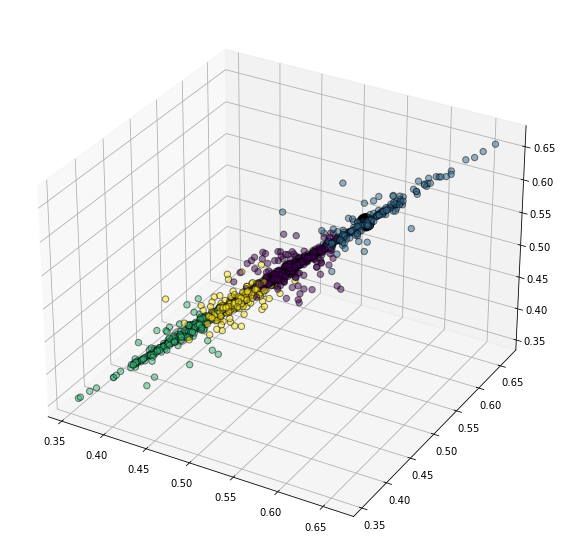

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ts_paa[:,0],ts_paa[:,1],ts_paa[:,2],
            c=label, cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)

# ax.set_title("First three PCA directions")

ax.scatter(clusters[:,0], clusters[:,1],
           clusters[:,2], clusters[:,3],
           s = 300, color='k', label = 'Centroid')

plt.autoscale(enable=True, axis='x', tight=True)

plt.show()

#### Shapelet Discovery

In [ ]:
n_paa_segments = 1000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
clusters_paa = paa.fit_transform(clusters)

clusters_paa.shape

(4, 1000, 1)

In [ ]:
data_ts = pd.DataFrame(clusters[:,:,0])

In [ ]:
n_ts, ts_sz = data_ts.shape

In [ ]:
n_classes = len(np.unique(Y_train["emotion"]))

In [ ]:
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=0.1, r=1)

print('Number of time series:', n_ts)
print('Time series size:', ts_sz)
print('n_classes:', n_classes)
print('shapelet_sizes:', shapelet_sizes)

Number of time series: 4
Time series size: 5000
n_classes: 8
shapelet_sizes: {500: 5}


In [ ]:
y_train = ["angry", "happy", "sad", "happy"]

In [ ]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0,
                        random_state=0)

shp_clf.fit(data_ts, y_train)

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(max_iter=200, n_shapelets_per_size={500: 5}, random_state=0,
                  weight_regularizer=0.01)

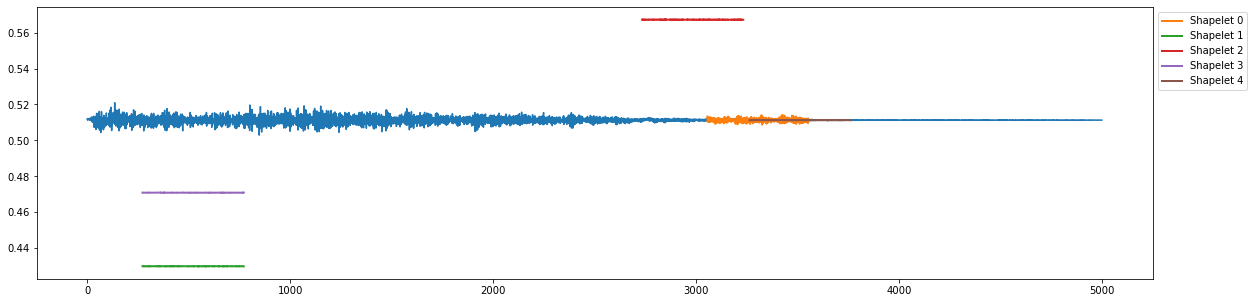

In [ ]:
predicted_locations = shp_clf.locate(data_ts)

ts_id = 0
plt.figure(figsize=(20,5))
n_shapelets = sum(shapelet_sizes.values())
# plt.title("Example locations of shapelet matches in first cluster")
plt.plot(data_ts.iloc[ts_id,:])
# plt.xlim([200,3000])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2, label = 'Shapelet {}'.format(idx_shp))
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

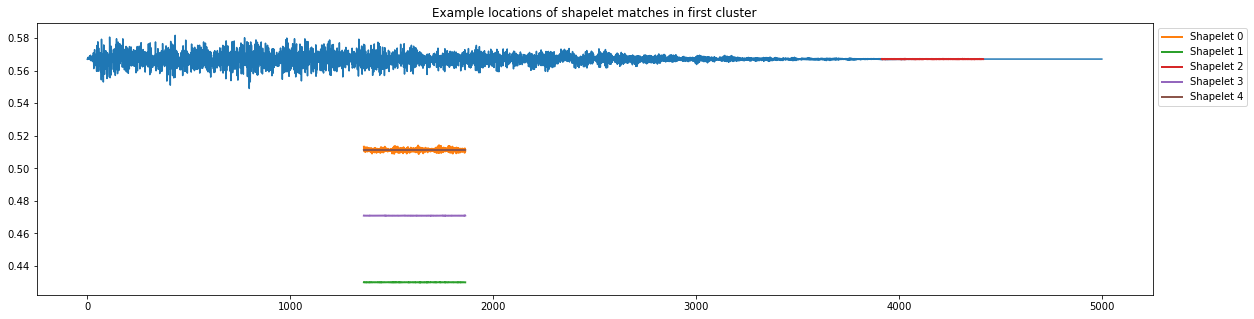

In [ ]:
predicted_locations = shp_clf.locate(data_ts)

ts_id = 1
plt.figure(figsize=(20,5))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches in first cluster")
plt.plot(data_ts.iloc[ts_id,:])
# plt.xlim([200,3000])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2, label = 'Shapelet {}'.format(idx_shp))
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

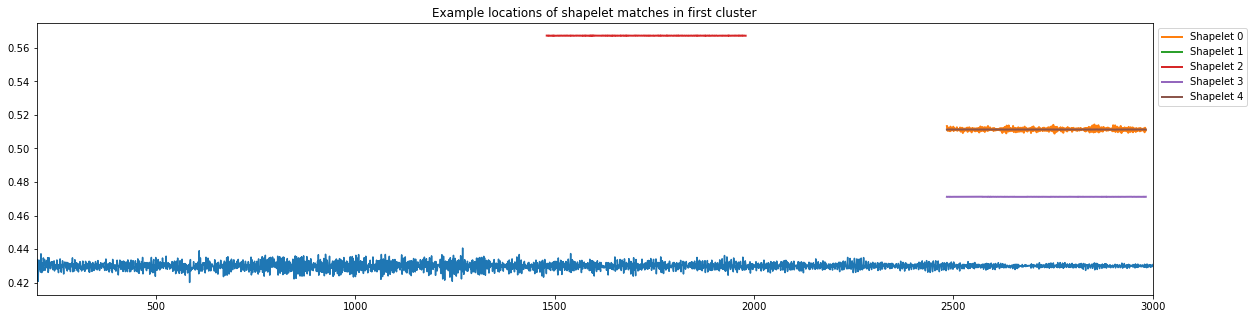

In [ ]:
predicted_locations = shp_clf.locate(data_ts)

ts_id = 2
plt.figure(figsize=(20,5))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches in first cluster")
plt.plot(data_ts.iloc[ts_id,:])
plt.xlim([200,3000])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2, label = 'Shapelet {}'.format(idx_shp))
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

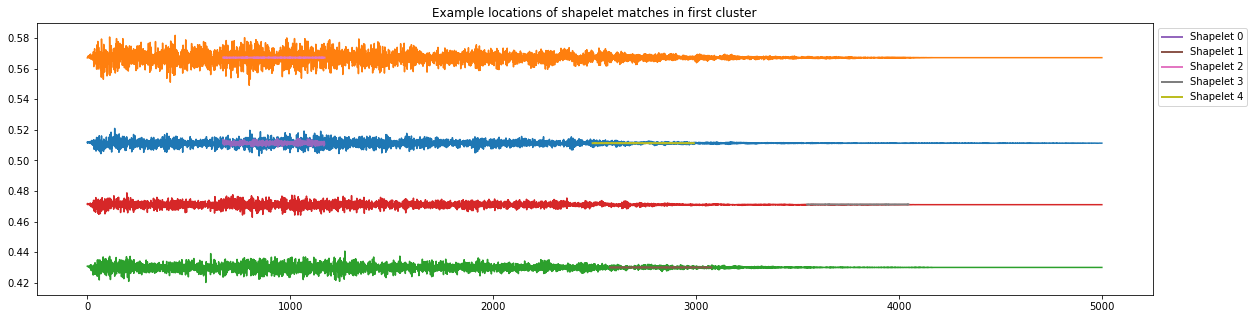

In [ ]:
predicted_locations = shp_clf.locate(data_ts)

ts_id = 3
plt.figure(figsize=(20,5))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches in first cluster")
plt.plot(data_ts.iloc[0,:])
plt.plot(data_ts.iloc[1,:])
plt.plot(data_ts.iloc[2,:])
plt.plot(data_ts.iloc[3,:])
# plt.xlim([200,3000])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2, label = 'Shapelet {}'.format(idx_shp))
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

In [ ]:
n_ts, ts_sz = ts_paa[:,:,0].shape
n_classes = len(np.unique(Y_train["emotion"]))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=0.1, r=1)

print('Number of time series:', n_ts)
print('Time series size:', ts_sz)
print('n_classes:', n_classes)
print('shapelet_sizes:', shapelet_sizes)

Number of time series: 1828
Time series size: 5000
n_classes: 8
shapelet_sizes: {500: 7}


In [ ]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0,
                        random_state=0)

shp_clf.fit(ts_paa[:,:,0], Y_train["emotion"])

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(max_iter=200, n_shapelets_per_size={500: 7}, random_state=0,
                  weight_regularizer=0.01)

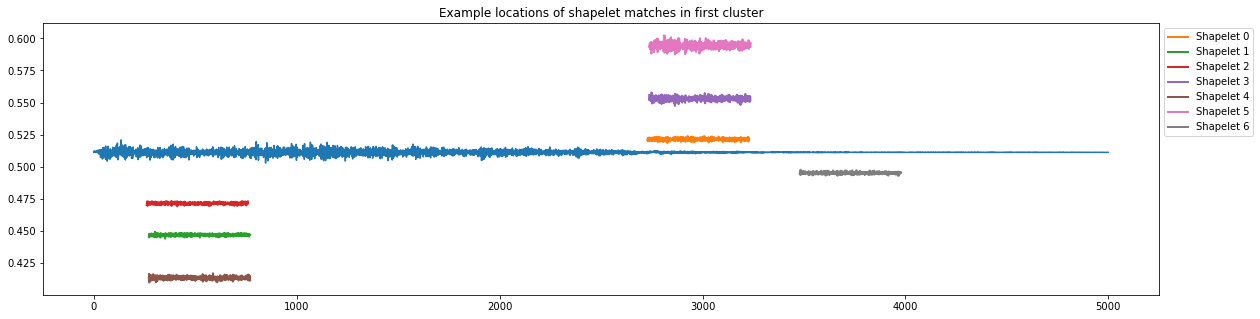

In [ ]:
predicted_locations = shp_clf.locate(data_ts)

ts_id = 0
plt.figure(figsize=(20,5))
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches in first cluster")
plt.plot(data_ts.iloc[ts_id,:])
# plt.xlim([200,3000])
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2, label = 'Shapelet {}'.format(idx_shp))
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

#### Motifs Discovery

In [ ]:
clusters = clusters[:,:,0]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
data_ts = pd.DataFrame((clusters-clusters.min())/(clusters.max()-clusters.min()))

In [ ]:
data_ts.shape

(4, 5000)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_ts = paa.fit_transform(data_ts)

data_ts.shape

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 4 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(4, 2000, 1)

In [ ]:
data_ts = pd.DataFrame(data_ts[:,:,0])

In [ ]:
data_ts.shape

(4, 2000)

In [ ]:
ts = data_ts.iloc[0,:]

In [ ]:
ts.shape

(5000,)

In [ ]:
w = 12
mp, mpi = matrixProfile.stomp(ts.values, w)

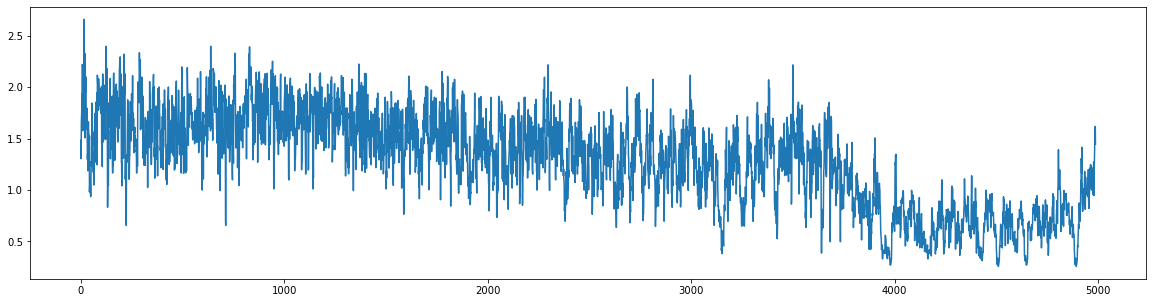

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(mp)
plt.show()

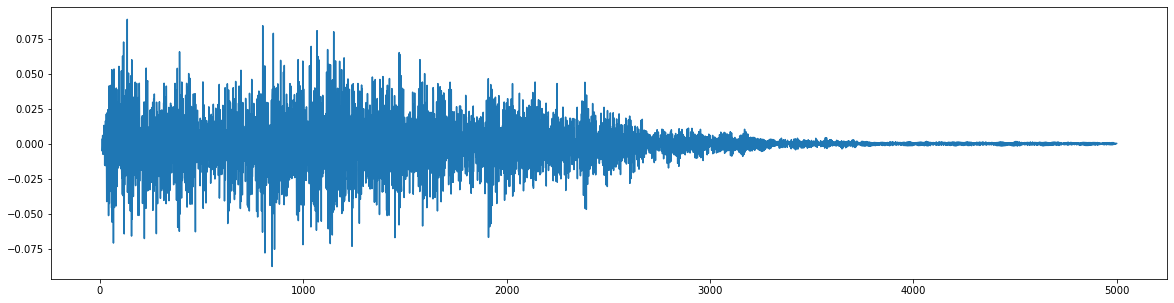

In [ ]:
ts_log_mov_diff = pd.Series(np.log(ts) - np.log(ts).rolling(w, center=False).mean(), index=ts.index)

plt.figure(figsize=(20,5))
plt.plot(ts_log_mov_diff)
# plt.xlim([0,127])
plt.show()

In [ ]:
mo, mod  = motifs.motifs(ts.values, (mp, mpi), max_motifs=5)

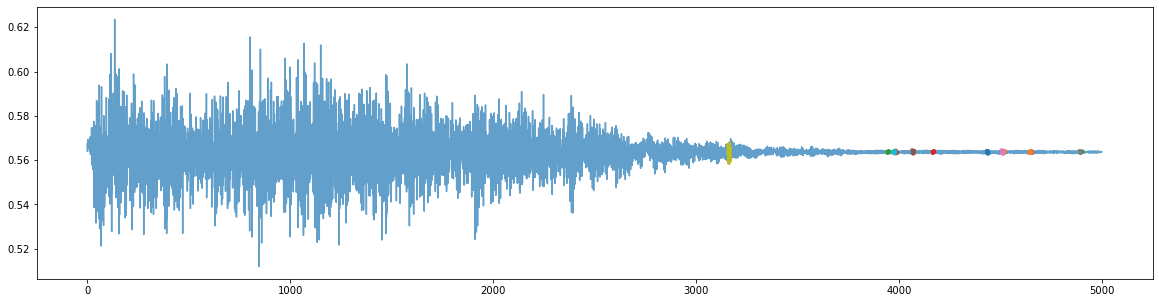

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ts, alpha=.7)
# plt.xlim([3000,5000])
colors = ['seagreen', 'darkorange', 'blueviolet', 'orchid', 'maroon'][:len(mo)]
for m, d, c in zip(mo, mod, colors):
#     plt.title('Motifs found in total_acc_x_train[3245]')
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, lw=3)
# plt.savefig('FigXX-Motifs.png', dpi=600)
plt.show()

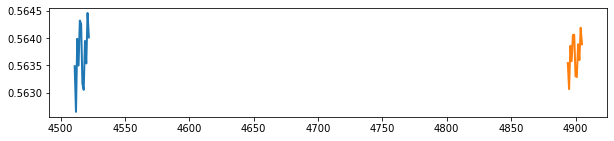

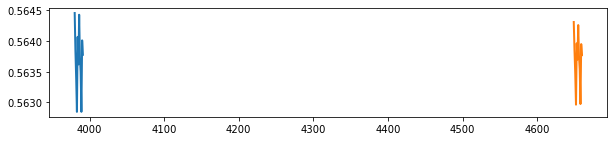

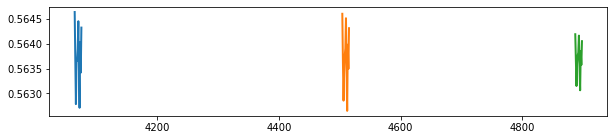

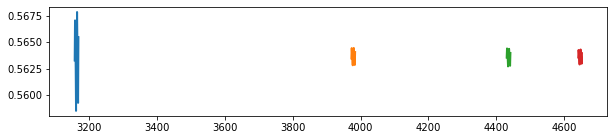

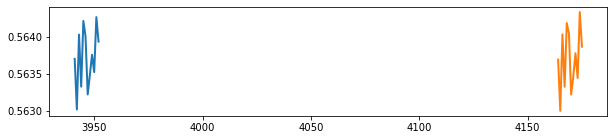

In [ ]:
for m, d, c in zip(mo, mod, colors):
    plt.figure(figsize=(10,2))
    for i in m:
        m_shape = ts.values[i:i+w]
        plt.plot(range(i,i+w), m_shape, lw=2)
#     plt.savefig('FigXX-'+str(i)+'Motif.png', dpi=600)
    plt.show()

#### Anomaly Discovery

In [ ]:
anoms = discords(mp, ex_zone=3, k=5)
anoms

array([ 16, 638, 123, 829, 287])

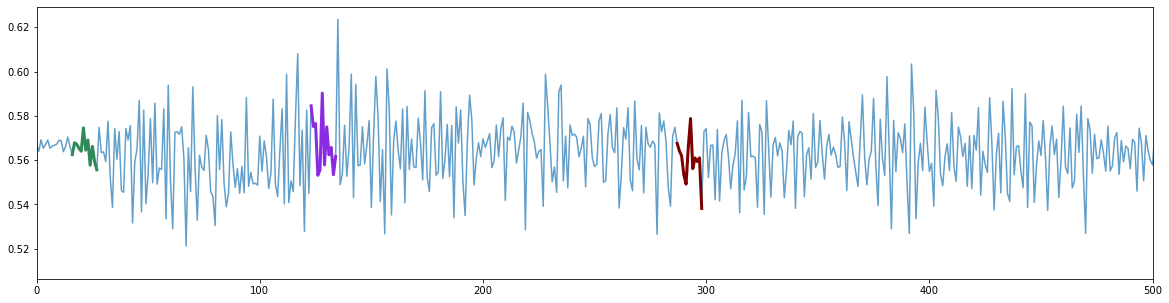

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(ts, alpha=.7)
plt.xlim([0,500])
# plt.title('Anomalies found in total_acc_x_train[3245]')
colors = ['seagreen', 'darkorange', 'blueviolet', 'orchid', 'maroon'][:len(mo)]
for a, c in zip(anoms, colors):
    a_shape = ts.values[a:a+w]
    plt.plot(range(a, a+w), a_shape, color=c, lw=3)
# plt.savefig('FigXX-TSAnomalies.png', dpi=600)
plt.show()

## **<font color="#FBBF44">8.x Classification</font>**

### Classification using Euclidean Distance

In [ ]:
mask_speechM = (Y_train['vocal_channel']=='speech')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_speechM = Y_train.index[mask_speechM]

mask_speechF = (Y_train['vocal_channel']=='speech')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_speechF = Y_train.index[mask_speechF]


In [ ]:
X_train_speech = X_train[np.r_[indices_speechM, indices_speechF]]


In [ ]:
X_train_speech.shape

(540, 110080)

In [ ]:
Y_train_speech = Y_train.loc[np.r_[indices_speechM, indices_speechF]]
Y_train_speech = Y_train_speech["emotion"]

In [ ]:
Y_train_speech.shape

(540,)

In [ ]:
mask_speechM = (Y_test['vocal_channel']=='speech')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_speechM = Y_test.index[mask_speechM]

mask_speechF = (Y_test['vocal_channel']=='speech')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_speechF = Y_test.index[mask_speechF]


In [ ]:
X_test_speech = X_test[np.r_[indices_speechM, indices_speechF]]


In [ ]:
X_test_speech.shape

(180, 110080)

In [ ]:
Y_test_speech = Y_test.loc[np.r_[indices_speechM, indices_speechF]]
Y_test_speech = Y_test_speech["emotion"]

In [ ]:
Y_test_speech.shape

(180,)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_train = paa.fit_transform(X_train_speech)

data_train.shape

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 540 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(540, 2000, 1)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_test = paa.fit_transform(X_test_speech)

data_test.shape

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 180 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(180, 2000, 1)

In [ ]:
x_train = pd.DataFrame(data_train[:,:,0])
x_test = pd.DataFrame(data_test[:,:,0])

In [ ]:
scaler = TimeSeriesScalerMinMax()
x_train = scaler.fit_transform(x_train).reshape(x_train.shape[0], x_train.shape[1])
x_test = scaler.fit_transform(x_test).reshape(x_test.shape[0], x_test.shape[1])

In [ ]:
x_test.shape

(180, 2000)

In [ ]:
clf = KNeighborsClassifier()
clf.fit(x_train, Y_train_speech)

y_pred = clf.predict(x_test)

print('Accuracy %s' % accuracy_score(Y_test_speech, y_pred))
print('F1-score %s' % f1_score(Y_test_speech, y_pred, average=None))
print(classification_report(Y_test_speech, y_pred))

Accuracy 0.12222222222222222
F1-score [0.19469027 0.07692308 0.06451613 0.08163265 0.11320755 0.
 0.10526316 0.11111111]
              precision    recall  f1-score   support

       angry       0.12      0.46      0.19        24
        calm       0.50      0.04      0.08        24
     disgust       0.14      0.04      0.06        24
     fearful       0.08      0.08      0.08        24
       happy       0.10      0.12      0.11        24
     neutral       0.00      0.00      0.00        12
         sad       0.14      0.08      0.11        24
   surprised       0.17      0.08      0.11        24

    accuracy                           0.12       180
   macro avg       0.16      0.11      0.09       180
weighted avg       0.17      0.12      0.10       180



In [ ]:
y_train = Y_train["vocal_channel"]
y_test = Y_test["vocal_channel"]

In [ ]:
clf = KNeighborsClassifier()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.6009615384615384
F1-score [0.18360656 0.7359491 ]
              precision    recall  f1-score   support

        song       0.68      0.11      0.18       264
      speech       0.60      0.96      0.74       360

    accuracy                           0.60       624
   macro avg       0.64      0.53      0.46       624
weighted avg       0.63      0.60      0.50       624



### Classification using DTW

In [ ]:
mask_happyM = (Y_train['emotion']=='happy')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_happyM = Y_train.index[mask_happyM]

mask_happyF = (Y_train['emotion']=='happy')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_happyF = Y_train.index[mask_happyF]

mask_sadM = (Y_train['emotion']=='sad')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_sadM = Y_train.index[mask_sadM]

mask_sadF = (Y_train['emotion']=='sad')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_sadF = Y_train.index[mask_sadF]

mask_calmM = (Y_train['emotion']=='calm')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_calmM = Y_train.index[mask_calmM]

mask_calmF = (Y_train['emotion']=='calm')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_calmF = Y_train.index[mask_calmF]

mask_angryM = (Y_train['emotion']=='angry')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_angryM = Y_train.index[mask_angryM]

mask_angryF = (Y_train['emotion']=='angry')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_angryF = Y_train.index[mask_angryF]

In [ ]:
X_train_four = X_train[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]


In [ ]:
X_train_four.shape

(560, 110080)

In [ ]:
Y_train_four = Y_train.loc[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]
Y_train_four = Y_train_four["vocal_channel"]

In [ ]:
Y_train_four.shape

(560,)

In [ ]:
mask_happyM = (Y_test['emotion']=='happy')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_happyM = Y_test.index[mask_happyM]

mask_happyF = (Y_test['emotion']=='happy')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_happyF = Y_test.index[mask_happyF]

mask_sadM = (Y_test['emotion']=='sad')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_sadM = Y_test.index[mask_sadM]

mask_sadF = (Y_test['emotion']=='sad')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_sadF = Y_test.index[mask_sadF]

mask_calmM = (Y_test['emotion']=='calm')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_calmM = Y_test.index[mask_calmM]

mask_calmF = (Y_test['emotion']=='calm')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_calmF = Y_test.index[mask_calmF]

mask_angryM = (Y_test['emotion']=='angry')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_angryM = Y_test.index[mask_angryM]

mask_angryF = (Y_test['emotion']=='angry')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_angryF = Y_test.index[mask_angryF]

In [ ]:
X_test_four = X_test[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]


In [ ]:
X_test_four.shape

(192, 110080)

In [ ]:
Y_test_four = Y_test.loc[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]
Y_test_four = Y_test_four["vocal_channel"]

In [ ]:
Y_test_four.shape

(192,)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_train = paa.fit_transform(X_train_four)

data_train.shape

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 560 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(560, 2000, 1)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_test = paa.fit_transform(X_test_four)

data_test.shape

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 192 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


(192, 2000, 1)

In [ ]:
x_train = pd.DataFrame(data_train[:,:,0])
x_test = pd.DataFrame(data_test[:,:,0])

In [ ]:
scaler = TimeSeriesScalerMinMax()
x_train = scaler.fit_transform(x_train).reshape(x_train.shape[0], x_train.shape[1])
x_test = scaler.fit_transform(x_test).reshape(x_test.shape[0], x_test.shape[1])

In [ ]:
x_train.shape, x_test.shape

((560, 2000), (192, 2000))

In [ ]:
metric_p = {
    "sakoe_chiba_radius": 2
}

In [ ]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba', metric_params=metric_p)
clf.fit(x_train, Y_train_four)

y_pred = clf.predict(x_test)

print('Accuracy %s' % accuracy_score(Y_test_four, y_pred))
print('F1-score %s' % f1_score(Y_test_four, y_pred, average=None))
print(classification_report(Y_test_four, y_pred))

Accuracy 0.90625
F1-score [0.90526316 0.90721649]
              precision    recall  f1-score   support

        song       0.91      0.90      0.91        96
      speech       0.90      0.92      0.91        96

    accuracy                           0.91       192
   macro avg       0.91      0.91      0.91       192
weighted avg       0.91      0.91      0.91       192



In [ ]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba', metric_params=metric_p)
clf.fit(x_train, Y_train_speech)

y_pred = clf.predict(x_test)

print('Accuracy %s' % accuracy_score(Y_test_speech, y_pred))
print('F1-score %s' % f1_score(Y_test_speech, y_pred, average=None))
print(classification_report(Y_test_speech, y_pred))

Accuracy 0.2388888888888889
F1-score [0.44444444 0.46666667 0.2173913  0.05128205 0.1        0.08333333
 0.14814815 0.23076923]
              precision    recall  f1-score   support

       angry       0.48      0.42      0.44        24
        calm       0.39      0.58      0.47        24
     disgust       0.23      0.21      0.22        24
     fearful       0.07      0.04      0.05        24
       happy       0.12      0.08      0.10        24
     neutral       0.08      0.08      0.08        12
         sad       0.13      0.17      0.15        24
   surprised       0.21      0.25      0.23        24

    accuracy                           0.24       180
   macro avg       0.21      0.23      0.22       180
weighted avg       0.22      0.24      0.23       180



### Shapelet-Based Classification

In [ ]:
n_ts, ts_sz = x_train.shape
n_classes = len(set(Y_train_four))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=0.15
print('Number of time series:', n_ts)
print('Time series size:', ts_sz)
print('n_classes:', n_classes)
print('shapelet_sizes:', shapelet_sizes)

Number of time series: 560
Time series size: 2000
n_classes: 2
shapelet_sizes: {300: 5}


In [ ]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0,
                        random_state=0)

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [ ]:
shp_clf.fit(x_train, Y_train_four)
y_pred = shp_clf.predict(x_test)

print('Accuracy %s' % accuracy_score(Y_test_four, y_pred))
print('F1-score %s' % f1_score(Y_test_four, y_pred, average=None))
print(classification_report(Y_test_four, y_pred))

Accuracy 0.5
F1-score [0.         0.66666667]
              precision    recall  f1-score   support

        song       0.00      0.00      0.00        96
      speech       0.50      1.00      0.67        96

    accuracy                           0.50       192
   macro avg       0.25      0.50      0.33       192
weighted avg       0.25      0.50      0.33       192



/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train2_ts = shp_clf.transform(x_train)
X_test2_ts = shp_clf.transform(x_test)

X_train2_ts.shape

(560, 5)

In [ ]:
clf = KNeighborsClassifier()
clf.fit(X_train2_ts, Y_train_four)

y_pred = clf.predict(X_test2_ts)

print('Accuracy %s' % accuracy_score(Y_test_four, y_pred))
print('F1-score %s' % f1_score(Y_test_four, y_pred, average=None))
print(classification_report(Y_test_four, y_pred))

Accuracy 0.5885416666666666
F1-score [0.58638743 0.59067358]
              precision    recall  f1-score   support

        song       0.59      0.58      0.59        96
      speech       0.59      0.59      0.59        96

    accuracy                           0.59       192
   macro avg       0.59      0.59      0.59       192
weighted avg       0.59      0.59      0.59       192



In [ ]:
n_ts, ts_sz = x_train.shape
n_classes = len(set(Y_train_speech))

shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=0.15, r=1)

print('Number of time series:', n_ts)
print('Time series size:', ts_sz)
print('n_classes:', n_classes)
print('shapelet_sizes:', shapelet_sizes)

Number of time series: 540
Time series size: 2000
n_classes: 8
shapelet_sizes: {300: 6}


In [ ]:
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="sgd",
                        weight_regularizer=.01,
                        max_iter=200,
                        verbose=0,
                        random_state=0)

/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [ ]:
shp_clf.fit(x_train, Y_train_speech)
y_pred = shp_clf.predict(x_test)

print('Accuracy %s' % accuracy_score(Y_test_speech, y_pred))
print('F1-score %s' % f1_score(Y_test_speech, y_pred, average=None))
print(classification_report(Y_test_speech, y_pred))

Accuracy 0.1388888888888889
F1-score [0.         0.07407407 0.         0.23880597 0.         0.
 0.         0.        ]
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        24
        calm       0.33      0.04      0.07        24
     disgust       0.00      0.00      0.00        24
     fearful       0.14      1.00      0.24        24
       happy       0.00      0.00      0.00        24
     neutral       0.00      0.00      0.00        12
         sad       0.00      0.00      0.00        24
   surprised       0.00      0.00      0.00        24

    accuracy                           0.14       180
   macro avg       0.06      0.13      0.04       180
weighted avg       0.06      0.14      0.04       180



/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mumer/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_train2_ts = shp_clf.transform(x_train)
X_test2_ts = shp_clf.transform(x_test)

X_train2_ts.shape

(540, 6)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train2_ts, Y_train_speech)

y_pred = clf.predict(X_test2_ts)

print('Accuracy %s' % accuracy_score(Y_test_speech, y_pred))
print('F1-score %s' % f1_score(Y_test_speech, y_pred, average=None))
print(classification_report(Y_test_speech, y_pred))

Accuracy 0.12777777777777777
F1-score [0.25531915 0.04878049 0.21818182 0.04545455 0.05       0.08333333
 0.16949153 0.08      ]
              precision    recall  f1-score   support

       angry       0.26      0.25      0.26        24
        calm       0.06      0.04      0.05        24
     disgust       0.19      0.25      0.22        24
     fearful       0.05      0.04      0.05        24
       happy       0.06      0.04      0.05        24
     neutral       0.08      0.08      0.08        12
         sad       0.14      0.21      0.17        24
   surprised       0.08      0.08      0.08        24

    accuracy                           0.13       180
   macro avg       0.12      0.12      0.12       180
weighted avg       0.12      0.13      0.12       180



### Advance Classification

In [ ]:
#Multiclass using only speech
mask_speechM = (Y_train['vocal_channel']=='speech')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_speechM = Y_train.index[mask_speechM]

mask_speechF = (Y_train['vocal_channel']=='speech')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_speechF = Y_train.index[mask_speechF]

In [ ]:
X_train_speech = X_train[np.r_[indices_speechM, indices_speechF]]
X_train_speech.shape

(540, 110080)

In [ ]:
Y_train_speech = Y_train.loc[np.r_[indices_speechM, indices_speechF]]
Y_train_speech = Y_train_speech["emotion"]
Y_train_speech.shape

(540,)

In [ ]:
mask_speechM = (Y_test['vocal_channel']=='speech')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_speechM = Y_test.index[mask_speechM]

mask_speechF = (Y_test['vocal_channel']=='speech')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_speechF = Y_test.index[mask_speechF]

In [ ]:
X_test_speech = X_test[np.r_[indices_speechM, indices_speechF]]
X_test_speech.shape

(180, 110080)

In [ ]:
Y_test_speech = Y_test.loc[np.r_[indices_speechM, indices_speechF]]
Y_test_speech = Y_test_speech["emotion"]
Y_test_speech.shape

(180,)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_train_speech = paa.fit_transform(X_train_speech)

data_train_speech.shape

(540, 2000, 1)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_test = paa.fit_transform(X_test_speech)

data_test.shape

(180, 2000, 1)

In [ ]:
X_train_speech = pd.DataFrame(data_train_speech[:,:,0])
X_test_speech = pd.DataFrame(data_test[:,:,0])

In [ ]:
scaler = TimeSeriesScalerMinMax()
X_train_speech = scaler.fit_transform(X_train_speech).reshape(X_train_speech.shape[0], X_train_speech.shape[1])
X_test_speech = scaler.fit_transform(X_test_speech).reshape(X_test_speech.shape[0], X_test_speech.shape[1])

In [ ]:
X_train_lstm = X_train_speech.reshape((X_train_speech.shape[0], X_train_speech.shape[1], 1))
X_test_lstm = X_test_speech.reshape((X_test_speech.shape[0], X_test_speech.shape[1], 1))

X_train_lstm, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_lstm, Y_train_speech, test_size=0.2, stratify=Y_train_speech)

n_timesteps, n_outputs, n_features = X_train_lstm.shape[1], len(np.unique(Y_train_speech)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  2000
N. LABELS:  8


In [ ]:
pre = preprocessing.LabelEncoder()
b = np.unique(y_train_cnn)
pre.fit(b)
c = pre.transform(y_train_cnn)
y_train_cnn = pd.Series(c)
y_val_cnn = pd.Series(pre.transform(y_val_cnn))

In [ ]:
Y_test_speech = pd.Series(pre.transform(Y_test_speech))

In [ ]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation='sigmoid'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
lstm = build_lstm(n_timesteps, n_outputs)
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 281,160
Trainable params: 281,160
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=0)
mc = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_lstm.shape[0]/10, batch_size))

history_lstm = lstm.fit(X_train_lstm, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/5
27/27 [==============================] - 219s 8s/step - loss: 2.0786 - accuracy: 0.1065 - val_loss: 2.0682 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 2/5
27/27 [==============================] - 139s 5s/step - loss: 2.0745 - accuracy: 0.1435 - val_loss: 2.0651 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 3/5
27/27 [==============================] - 139s 5s/step - loss: 2.0743 - accuracy: 0.1042 - val_loss: 2.0649 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 4/5
27/27 [==============================] - 136s 5s/step - loss: 2.0754 - accuracy: 0.1366 - val_loss: 2.0649 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 5/5
27/27 [==============================] - 136s 5s/step - loss: 2.0694 - accuracy: 0.1204 - val_loss: 2.0635 - val_accuracy: 0.1296 - lr: 0.0010


In [ ]:
y_pred = np.argmax(lstm.predict(X_test_lstm), axis=1)

6/6 [==============================] - 26s 4s/step


NameError: ignored

In [ ]:
print('Accuracy %s' % accuracy_score(Y_test_speech, y_pred))
print('F1-score %s' % f1_score(Y_test_speech, y_pred, average=None))
print(classification_report(Y_test_speech, y_pred))

lstm.evaluate(X_test_lstm, Y_test_speech)

Accuracy 0.13333333333333333
F1-score [0.         0.         0.         0.         0.         0.
 0.23529412 0.        ]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00        12
           6       0.13      1.00      0.24        24
           7       0.00      0.00      0.00        24

    accuracy                           0.13       180
   macro avg       0.02      0.12      0.03       180
weighted avg       0.02      0.13      0.03       180

6/6 [==============================] - 20s 3s/step - loss: 2.0653 - accuracy: 0.1333


[2.0653223991394043, 0.13333334028720856]

In [ ]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
cnn = build_simple_cnn(n_timesteps, n_outputs)
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1993, 16)          144       
                                                                 
 batch_normalization (BatchN  (None, 1993, 16)         64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1993, 16)          0         
                                                                 
 dropout_4 (Dropout)         (None, 1993, 16)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1989, 32)          2592      
                                                                 
 batch_normalization_1 (Batc  (None, 1989, 32)         128       
 hNormalization)                                      

In [ ]:
X_train_cnn = X_train_speech.reshape((X_train_speech.shape[0], X_train_speech.shape[1], 1))
X_test_cnn = X_test_speech.reshape((X_test_speech.shape[0], X_test_speech.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, Y_train_speech, test_size=0.2, stratify=Y_train_speech)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(Y_train_speech)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  2000
N. LABELS:  8


In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))

history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/5
27/27 [==============================] - 18s 447ms/step - loss: 2.1317 - accuracy: 0.1343 - val_loss: 2.0781 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 2/5
27/27 [==============================] - 10s 358ms/step - loss: 2.0660 - accuracy: 0.1667 - val_loss: 2.0773 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 3/5
27/27 [==============================] - 11s 414ms/step - loss: 2.0565 - accuracy: 0.1597 - val_loss: 2.0764 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 4/5
27/27 [==============================] - 11s 390ms/step - loss: 2.0416 - accuracy: 0.1806 - val_loss: 2.0756 - val_accuracy: 0.1296 - lr: 0.0010
Epoch 5/5
27/27 [==============================] - 12s 429ms/step - loss: 2.0338 - accuracy: 0.1713 - val_loss: 2.0746 - val_accuracy: 0.1296 - lr: 0.0010


In [ ]:
mask_happyM = (Y_train['emotion']=='happy')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_happyM = Y_train.index[mask_happyM]

mask_happyF = (Y_train['emotion']=='happy')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_happyF = Y_train.index[mask_happyF]

mask_sadM = (Y_train['emotion']=='sad')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_sadM = Y_train.index[mask_sadM]

mask_sadF = (Y_train['emotion']=='sad')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_sadF = Y_train.index[mask_sadF]

mask_calmM = (Y_train['emotion']=='calm')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_calmM = Y_train.index[mask_calmM]

mask_calmF = (Y_train['emotion']=='calm')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_calmF = Y_train.index[mask_calmF]

mask_angryM = (Y_train['emotion']=='angry')&(Y_train['sex']=='M')&(Y_train["statement"]=='Kids are talking by the door')

indices_angryM = Y_train.index[mask_angryM]

mask_angryF = (Y_train['emotion']=='angry')&(Y_train['sex']=='F')&(Y_train["statement"]=='Kids are talking by the door')

indices_angryF = Y_train.index[mask_angryF]

In [ ]:
X_train_four = X_train[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]
X_train_four.shape

(560, 110080)

In [ ]:
Y_train_four = Y_train.loc[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]
Y_train_four = Y_train_four["vocal_channel"]
Y_train_four.shape

(560,)

In [ ]:
mask_happyM = (Y_test['emotion']=='happy')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_happyM = Y_test.index[mask_happyM]

mask_happyF = (Y_test['emotion']=='happy')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_happyF = Y_test.index[mask_happyF]

mask_sadM = (Y_test['emotion']=='sad')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_sadM = Y_test.index[mask_sadM]

mask_sadF = (Y_test['emotion']=='sad')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_sadF = Y_test.index[mask_sadF]

mask_calmM = (Y_test['emotion']=='calm')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_calmM = Y_test.index[mask_calmM]

mask_calmF = (Y_test['emotion']=='calm')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_calmF = Y_test.index[mask_calmF]

mask_angryM = (Y_test['emotion']=='angry')&(Y_test['sex']=='M')&(Y_test["statement"]=='Kids are talking by the door')

indices_angryM = Y_test.index[mask_angryM]

mask_angryF = (Y_test['emotion']=='angry')&(Y_test['sex']=='F')&(Y_test["statement"]=='Kids are talking by the door')

indices_angryF = Y_test.index[mask_angryF]

In [ ]:
X_test_four = X_test[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]
X_test_four.shape

(192, 110080)

In [ ]:
Y_test_four = Y_test.loc[np.r_[indices_happyM, indices_happyF, indices_sadM, indices_sadF, indices_calmM, indices_calmF, indices_angryM, indices_angryF]]
Y_test_four = Y_test_four["vocal_channel"]
Y_test_four.shape

(192,)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_train = paa.fit_transform(X_train_four)

data_train.shape

(560, 2000, 1)

In [ ]:
n_paa_segments = 2000
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
data_test = paa.fit_transform(X_test_four)

data_test.shape

(192, 2000, 1)

In [ ]:
x_train_four = pd.DataFrame(data_train[:,:,0])
x_test_four = pd.DataFrame(data_test[:,:,0])

In [ ]:
scaler = TimeSeriesScalerMinMax()
x_train_four = scaler.fit_transform(x_train_four).reshape(x_train_four.shape[0], x_train_four.shape[1])
x_test_four = scaler.fit_transform(x_test_four).reshape(x_test_four.shape[0], x_test_four.shape[1])

In [ ]:
X_train_lstm = x_train_four.reshape((x_train_four.shape[0], x_train_four.shape[1], 1))
X_test_lstm = x_test_four.reshape((x_test_four.shape[0], x_test_four.shape[1], 1))

X_train_lstm, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_lstm, Y_train_four, test_size=0.2, stratify=Y_train_four)

n_timesteps, n_outputs, n_features = X_train_lstm.shape[1], len(np.unique(Y_train_four)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  2000
N. LABELS:  2


In [ ]:
pre = preprocessing.LabelEncoder()
b = np.unique(y_train_cnn)
pre.fit(b)
c = pre.transform(y_train_cnn)
y_train_cnn = pd.Series(c)
y_val_cnn = pd.Series(pre.transform(y_val_cnn))
Y_test_four = pd.Series(pre.transform(Y_test_four))

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=10, min_lr=0)
mc = ModelCheckpoint('best_model_lstm.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_lstm.shape[0]/10, batch_size))

history_lstm = lstm.fit(X_train_lstm, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/5
28/28 [==============================] - 234s 8s/step - loss: 1.2158 - accuracy: 0.3795 - val_loss: 0.6976 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 2/5
28/28 [==============================] - 194s 7s/step - loss: 0.7732 - accuracy: 0.5089 - val_loss: 0.6982 - val_accuracy: 0.4911 - lr: 0.0010
Epoch 3/5
28/28 [==============================] - 141s 5s/step - loss: 0.7523 - accuracy: 0.4955 - val_loss: 0.7140 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 4/5
28/28 [==============================] - 142s 5s/step - loss: 0.7518 - accuracy: 0.4598 - val_loss: 0.7038 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 5/5
28/28 [==============================] - 143s 5s/step - loss: 0.7326 - accuracy: 0.4933 - val_loss: 0.6948 - val_accuracy: 0.5179 - lr: 0.0010


In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)

callbacks = [rlr, mc]

batch_size = 16
mini_batch_size = int(min(X_train_lstm.shape[0]/10, batch_size))

history_cnn = cnn.fit(X_train_lstm, y_train_cnn, epochs=5, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/5
28/28 [==============================] - 11s 391ms/step - loss: 1.5936 - accuracy: 0.5312 - val_loss: 2.0083 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 2/5
28/28 [==============================] - 11s 389ms/step - loss: 0.9251 - accuracy: 0.6473 - val_loss: 1.9121 - val_accuracy: 0.4821 - lr: 0.0010
Epoch 3/5
28/28 [==============================] - 9s 329ms/step - loss: 0.7350 - accuracy: 0.7902 - val_loss: 1.9040 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 4/5
28/28 [==============================] - 11s 404ms/step - loss: 0.5957 - accuracy: 0.8482 - val_loss: 1.8953 - val_accuracy: 0.6786 - lr: 0.0010
Epoch 5/5
28/28 [==============================] - 11s 402ms/step - loss: 0.5067 - accuracy: 0.8438 - val_loss: 1.8910 - val_accuracy: 0.7321 - lr: 0.0010


In [ ]:
y_pred = np.argmax(lstm.predict(X_test_lstm), axis=1)

print('Accuracy %s' % accuracy_score(Y_test_four, y_pred))
print('F1-score %s' % f1_score(Y_test_four, y_pred, average=None))
print(classification_report(Y_test_four, y_pred))

lstm.evaluate(X_test_lstm, Y_test_four)

6/6 [==============================] - 25s 4s/step
Accuracy 0.5
F1-score [0.         0.66666667]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.50      1.00      0.67        96

    accuracy                           0.50       192
   macro avg       0.25      0.50      0.33       192
weighted avg       0.25      0.50      0.33       192

6/6 [==============================] - 25s 4s/step - loss: 0.6973 - accuracy: 0.5000


[0.6973279118537903, 0.5]

In [ ]:
y_pred = np.argmax(cnn.predict(X_test_lstm), axis=1)

print('Accuracy %s' % accuracy_score(Y_test_four, y_pred))
print('F1-score %s' % f1_score(Y_test_four, y_pred, average=None))
print(classification_report(Y_test_four, y_pred))

lstm.evaluate(X_test_lstm, Y_test_four)

6/6 [==============================] - 1s 119ms/step
Accuracy 0.859375
F1-score [0.83832335 0.87557604]
              precision    recall  f1-score   support

           0       0.99      0.73      0.84        96
           1       0.79      0.99      0.88        96

    accuracy                           0.86       192
   macro avg       0.89      0.86      0.86       192
weighted avg       0.89      0.86      0.86       192

6/6 [==============================] - 28s 5s/step - loss: 0.6973 - accuracy: 0.5000


[0.6973279118537903, 0.5]